In [1]:
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib import ticker, colors
import numpy as np
import pandas as pd
import os 
import scipy
import uproot
import glob
import yaml

np.seterr(divide='ignore', invalid='ignore')

#plt.style.use('physics.mplstyle')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
def get_limits(fn):
    f = uproot.open(fn)
    limit = f["limit"]['limit'].array(library="np")
    quant = f["limit"]['quantileExpected'].array(library="np")
    if limit.shape[0] == 1:
        return -1
    else:
        return np.stack([quant,limit])
    
def get_SUEP_file(Mass=125, mdark=2, t=1, decay="darkPho", path="./"):
    if t < 10:
        tem = "{0:.2f}".format(t)
    else:
        tem = "{0:.1f}".format(t)
    tem = str(tem).replace(".","p")
    fname = os.path.join(
        "../higgsCombineGluGluToSUEP_HT1000_T{}_mS{:.3f}_mPhi{:.3f}_T{:.3f}_mode{}.AsymptoticLimits.mH125.root".format(tem, Mass, mdark, t, decay)
    )
    if os.path.isfile(fname):
        return fname
    else:
        pass
    
xsec = {"125": 34.8, "400": 5.9, "750": 0.5, "1000": 0.17}
        
def log_interp1d(xx, yy, kind='linear'):
    logx = np.log(xx)
    logy = np.log(yy)
    lin_interp = interpolate.interp1d(logx, logy, bounds_error=False, fill_value="extrapolate", kind=kind)
    log_interp = lambda zz: np.power(np.e, lin_interp(np.log(zz)))
    return log_interp

In [3]:
combine_files = glob.glob("../higgs*.root")

In [35]:
all_params = []
for file in combine_files:
    file_trim = file.split("HT1000_")[1]
    t = float(file_trim.split("_")[0].replace("p",".")[1:])
    Mass = float(file_trim.split("_")[1][2:])
    mphi = float(file_trim.split("_")[2][4:])
    all_params.append([t,Mass,mphi])

In [46]:
M = 1000

In [47]:
params = []
for pair in all_params:
    if pair[1] != M: continue
    params.append([pair[2],pair[0]])

Text(0, 1, '$Temp$ (GeV)')

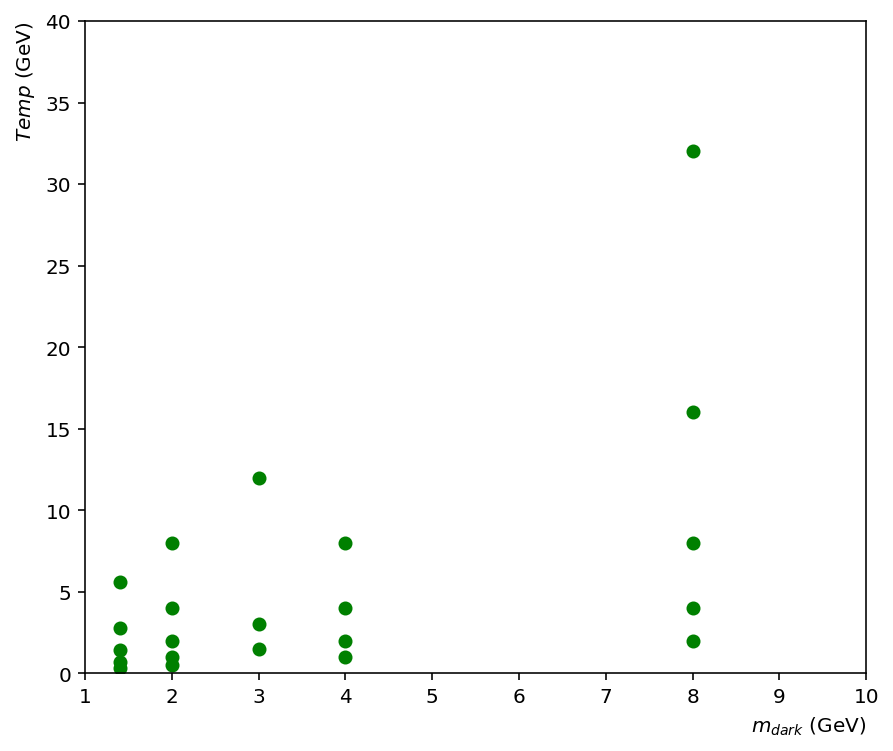

In [51]:
plt.figure(figsize=(7,6))

skip_bad = []

for pair in params:
    limit = get_limits(get_SUEP_file(Mass=M, mdark=pair[0] ,t=pair[1] ,decay='hadronic'))
    try:
        limit = get_limits(get_SUEP_file(Mass=M, mdark=pair[0] ,t=pair[1] ,decay='hadronic'))
        if limit.shape == (2,5):
            plt.scatter(pair[0],pair[1], color="green")
            skip_bad.append(pair)
        else:
            plt.scatter(pair[0],pair[1], color="blue", alpha=0.5)
    except:
        pass
        get_SUEP_file(Mass=M, mdark=pair[0] ,t=pair[1] ,decay='hadronic')
        plt.scatter(pair[1],pair[0], color="red")

params = skip_bad
        
plt.ylim([0, 40])
plt.xlim([1, 10])
plt.xlabel(r"$m_{dark}$ (GeV)", x=1, ha='right')
plt.ylabel(r"$Temp$ (GeV)", y=1, ha='right')

In [49]:
def plot_SUEP(unblind=False):
    limit_mH = []
    limit_ma = []
    limit_lm = []
    limit_xs = []
    mZ = 91.1876
    return_limit = []

    for pair in params:
        limit = get_limits(get_SUEP_file(Mass=M, mdark=pair[0] ,t=pair[1] ,decay='hadronic'))
        if limit.shape == (2, 5):
            limit_lm.append(limit)
            limit_ma.append(pair[0])
            limit_mH.append(pair[1])
            return_limit.append([pair[0], pair[1], limit[1,2]])
            limit_xs.append(xsec['125'])
        else:
            continue
            
    limit_lm = np.array(limit_lm)
    limit_mH = np.array(limit_mH)
    limit_ma = np.array(limit_ma)
    limit_xs = np.array(limit_xs)
    
    data = pd.DataFrame(
        {
            "mH"  : np.array(limit_mH),
            "ma"  : np.array(limit_ma),
            #"obs" : np.array(limit_lm)[:,1,5],
            "exp" : np.array(limit_lm)[:,1,2],
            "m1s" : np.array(limit_lm)[:,1,1],
            "p1s" : np.array(limit_lm)[:,1,3],
            "m2s" : np.array(limit_lm)[:,1,0],
            "p2s" : np.array(limit_lm)[:,1,4],
        }
    )
    plt.figure(figsize=(6,6))
    ax = plt.gca()

    #print(data)
    #levels = 10.**np.arange(-5,5,2)
    #x = plt.tricontourf(limit_ma, limit_mH, limit_lm[:,1,2], locator=ticker.LogLocator(), norm = colors.LogNorm(), cmap="Wistia")
    x = plt.tricontourf(limit_ma, limit_mH, limit_lm[:,1,2], cmap="Wistia")
    #formatter = ticker.LogFormatter(base=10.0, labelOnlyBase=True) 
    cb = plt.colorbar()
    #tick_locator = ticker.MaxNLocator(nbins=10)
    #cb.locator = ticker.LogLocator(base=10.0, subs=[1.0], numdecs=4, numticks=15)
    #cb.locator = tick_locator
    #plt.colorbar()
    #cb.update_ticks()
    print(limit_lm[:,1,2])

    p1 = plt.tricontour(limit_ma, limit_mH, limit_lm[:,1,1], colors="k", alpha=0)
    p2 = plt.tricontour(limit_ma, limit_mH, limit_lm[:,1,2], colors="k", alpha=0)
    p3 = plt.tricontour(limit_ma, limit_mH, limit_lm[:,1,3], colors="k", alpha=0)
    #p4 = plt.tricontour(limit_ma, limit_mH, limit_lm[:,1,5], colors="k", alpha=0)
    
    line1 = np.array(p1.collections[1].get_paths()[0].vertices)
    line2 = np.array(p2.collections[1].get_paths()[0].vertices)
    line3 = np.array(p3.collections[1].get_paths()[0].vertices)
    #line4 = np.array(p4.collections[1].get_paths()[0].vertices)

    #smooth_line = interpolate.Rbf(line[:,1], line[:,0], function="thin_plate")
    
    mH = np.linspace(200, 1400, 100)
    plt.plot(line1[:,0], line1[:,1], "r--", label="$\pm 1\sigma$ band")
    plt.plot(line2[:,0], line2[:,1], "b-", label="Expected $95\%$ CL")
    plt.plot(line3[:,0], line3[:,1], "r--")
    #plt.plot(line4[:,0], line4[:,1], "k-", label="Observed $95\%$ CL")
    #plt.fill_between(line1[:,0], line1[:,1], line3[:,0], line3[:,1])
        
    plt.xlabel(r"$m_{dark}$ (GeV)", x=1, ha='right')
    plt.ylabel(r"$Temp$ (GeV)", y=1, ha='right')
    cms = plt.text(
        0., 1., u"CMS $\it{preliminary}$",
        fontsize=16, fontweight='bold',
        horizontalalignment='left', 
        verticalalignment='bottom', 
        transform=ax.transAxes
    )
    lumi = plt.text(
        1., 1., r"%.1f fb$^{-1}$ (13 TeV)" % 60.0,
        fontsize=14, horizontalalignment='right', 
        verticalalignment='bottom', 
        transform=ax.transAxes
    )
    info = plt.text(
        0.05, 0.87, r"$M_{S} = 125$ GeV""\n""generic",
        fontsize=14, horizontalalignment='left', 
        verticalalignment='bottom', 
        transform=ax.transAxes
    )
    
    plt.xlim([1, 10])
    plt.ylim([0, 40])
    
    plt.legend(loc="upper right", fontsize=12)
    plt.tight_layout()
    plt.savefig("plots/Color_Temp_mdark_2D_limits.pdf", bbox_inches='tight')
    plt.savefig("plots/Color_Temp_mdark_2D_limits.png", bbox_inches='tight')
    return return_limit

[ 38.       14.0625   16.5625   16.75     21.96875  38.875    54.5
  11.53125 953.5      13.0625   14.75     13.125    16.3125  258.875
  12.0625   23.6875   11.8125  345.875    52.25     31.375    35.5
  12.625  ]


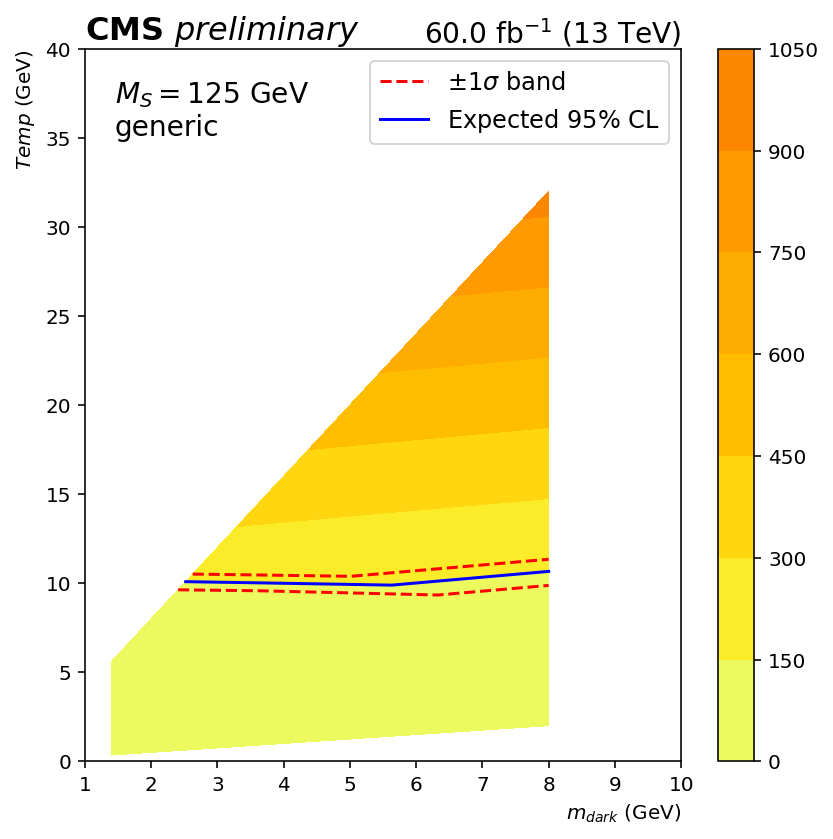

In [50]:
limit_result = plot_SUEP()

In [73]:
from matplotlib.legend_handler import HandlerLineCollection
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D


class HandlerDashedLines(HandlerLineCollection):
    """
    Custom Handler for LineCollection instances.
    """
    def create_artists(self, legend, orig_handle,
                   xdescent, ydescent, width, height, fontsize, trans):
        # figure out how many lines there are
        numlines = len(orig_handle.get_segments())
        xdata, xdata_marker = self.get_xdata(legend, xdescent, ydescent,
                                             width, height, fontsize)
        leglines = []
        # divide the vertical space where the lines will go

        ydata = (height/2.7) * np.ones(len(xdata), float)
        for i in range(numlines):
            legline = Line2D(xdata, ydata * (numlines - 2*i) - ydescent)
            self.update_prop(legline, orig_handle, legend)
            try:
                color = orig_handle.get_colors()[i]
            except IndexError:
                color = orig_handle.get_colors()[0]
            try:
                dashes = orig_handle.get_dashes()[i]
                #print ('dashes : ', dir(orig_handle))
            except IndexError:
                dashes = orig_handle.get_dashes()[0]
                #print ('dashes -> ', 0)
            try:
                lw = orig_handle.get_linewidths()[i]
            except IndexError:
                lw = orig_handle.get_linewidths()[0]
            if dashes[0] != None:
                legline.set_dashes(dashes[1])
            else:
                legline.set_linestyle('-')
            legline.set_color(color)
            legline.set_transform(trans)
            legline.set_linewidth(lw)
            leglines.append(legline)
        return leglines

In [74]:
def label_line(line, label, x, y, color='0.5', size=12):
    """Add a label to a line, at the proper angle.

    Arguments
    ---------
    line : matplotlib.lines.Line2D object,
    label : str
    x : float
        x-position to place center of text (in data coordinated
    y : float
        y-position to place center of text (in data coordinates)
    color : str
    size : float
    """
    xdata, ydata = line.get_data()
    x1 = xdata[0]
    x2 = xdata[-1]
    y1 = ydata[0]
    y2 = ydata[-1]

    ax = line.axes
    text = ax.annotate(label, xy=(x, y), xytext=(-10, 0),
                       textcoords='offset points',
                       size=size, color=color,
                       horizontalalignment='left',
                       verticalalignment='bottom')

    sp1 = ax.transData.transform_point((x1, y1))
    sp2 = ax.transData.transform_point((x2, y2))

    rise = (sp2[1] - sp1[1])
    run = (sp2[0] - sp1[0])

    slope_degrees = np.degrees(np.arctan2(rise, run))
    text.set_rotation(slope_degrees)
    return text

In [79]:
from scipy.ndimage import gaussian_filter1d

def interpLimit(limit, sigma=3):
    x, y = limit.T
    t  = np.linspace(0, 1, len(x))
    t2 = np.linspace(-0.9, 1.2, 100)

    x2 = np.interp(t2, t, x)
    y2 = np.interp(t2, t, y)
    
    x3 = gaussian_filter1d(x2, sigma)
    y3 = gaussian_filter1d(y2, sigma)
    x4 = np.interp(t, t2, x3)
    y4 = np.interp(t, t2, y3)

    return x3, y3

def interpolate2DLimit(unblind=False, smoothing=True, sigma=2, draw_mass_points=True, preliminary=False):
    limit_mH = []
    limit_ma = []
    limit_lm = []
    limit_xs = []
    mZ = 91.1876
    return_limit = []
    
    for pair in params:
        limit = get_limits(get_SUEP_file(Mass=400,mdark=pair[0],t=pair[1],decay='generic'))
        if limit.shape == (2, 6):
            limit_lm.append(limit)
            limit_ma.append(pair[0])
            limit_mH.append(pair[1])
            return_limit.append([pair[0], pair[1], limit[1,2]])
            limit_xs.append(xsec['400'])
            
    limit_lm = np.array(limit_lm)
    limit_mH = np.array(limit_mH)
    limit_ma = np.array(limit_ma)
    limit_xs = np.array(limit_xs)
    
    plt.figure(figsize=(6,6))
    ax = plt.gca()
        
    p1 = plt.tricontour(limit_ma, limit_mH, limit_lm[:,1,1], levels=[0,1], colors="k", alpha=0)
    p2 = plt.tricontour(limit_ma, limit_mH, limit_lm[:,1,2], levels=[0,1], colors="k", alpha=0)
    p3 = plt.tricontour(limit_ma, limit_mH, limit_lm[:,1,3], levels=[0,1], colors="k", alpha=0)
    p4 = plt.tricontour(limit_ma, limit_mH, limit_lm[:,1,5], levels=[0,1], colors="k", alpha=0)
    
    line1 = np.array(p1.collections[1].get_paths()[0].vertices)
    line2 = np.array(p2.collections[1].get_paths()[0].vertices)
    line3 = np.array(p3.collections[1].get_paths()[0].vertices)
    line4 = np.array(p4.collections[1].get_paths()[0].vertices)
    
    
    if smoothing:
        patch_exp = plt.plot(*interpLimit(line2, sigma), "b-")#, label="Expected $95\%$ CL")
        plt.plot(*interpLimit(line1, sigma), "r--")#, label="$\pm 1\sigma$ band")
        plt.plot(*interpLimit(line3, sigma), "r--")
        #patch_obs = plt.plot(*interpLimit(line4, sigma), "k-", label="Observed $95\%$ CL")
    else:
        patch_exp = plt.plot(line1[:,0], line1[:,1], "r--", label="$\pm 1\sigma$ band")
        plt.plot(line2[:,0], line2[:,1], "b-" )#, label="Expected $95\%$ CL")
        plt.plot(line3[:,0], line3[:,1], "r--")
        #patch_obs = plt.plot(line4[:,0], line3[:,1], "k-", label="Observed $95\%$ CL")
        
    if draw_mass_points: 
        plt.scatter(limit_ma, limit_mH, c=limit_lm[:,1,1], cmap="rainbow", label="Mass points")
    
    
    plt.xlabel(r"$m_{dark}$ (GeV)", x=1, ha='right')
    plt.ylabel(r"$Temp$ (GeV)", y=1, ha='right')
    
    plt.legend(loc="upper left", fontsize=14)
    #cms = plt.text(
    #    0.05, 0.9, u"CMS $\it{Preliminary}$" if preliminary else u"CMS",
    #    fontsize=18, fontweight='bold',
    #    horizontalalignment='left', 
    #    verticalalignment='bottom', 
    #    transform=ax.transAxes
    #)
    cms = plt.text(
        0., 1., u"CMS $\it{preliminary}$",
        fontsize=16, fontweight='bold',
        horizontalalignment='left', 
        verticalalignment='bottom', 
        transform=ax.transAxes
    )
    lumi = plt.text(
        1., 1., r"%1.0f fb$^{-1}$ (13 TeV)" % 61,
        fontsize=14, horizontalalignment='right', 
        verticalalignment='bottom', 
        transform=ax.transAxes
    )
    lumi = plt.text(
        0.05, 0.87, r"$M_{S} = 400$ GeV""\n""generic",
        fontsize=14, horizontalalignment='left', 
        verticalalignment='bottom', 
        transform=ax.transAxes
    )
    if draw_mass_points:
        plt.ylim([0, 11])
    else:
        plt.ylim([0, 11])
    plt.xlim([2, 5])
        
    ma = np.linspace(100, 600, 100)
    line = plt.plot(ma,  ma + 91.1876, "--", color="#57606f")
    label_line(line[0], r"${m}_{\rm H} = {m}_{\rm Z} + {m}_{\rm \sf{a}}$", 450, 550, color="#57606f", size=14)
    
    
    lc = LineCollection([np.column_stack([[0],[0]]) for i in np.arange(-1,2,1)],
                        linestyles = ['--', '-', '--'], colors = ['r', 'b', 'r'])
    
    #plt.legend(
    #    [lc, patch_obs[0]], [r"Expected $95\%$ CL $\pm\sigma_{\rm experiment}$", "Observed $95\%$ CL"], 
    #    handler_map = {type(lc) : HandlerDashedLines()}, 
    #    handlelength = 2.5, fontsize=12)
    
    #plt.legend(loc="upper right", fontsize=12, ncol= 2 if draw_mass_points else 1)
#     plt.grid(b=True, which='major', color='grey', linestyle='--', alpha=0.3)

    plt.savefig("plots/Temp_mdark_2D_limits-{}.pdf".format("-preliminary" if preliminary else ""), bbox_inches='tight')
    plt.savefig("plots/Temp_mdark_2D_limits-{}.png".format("-preliminary" if preliminary else ""), bbox_inches='tight')

    return line1, line2, line3

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


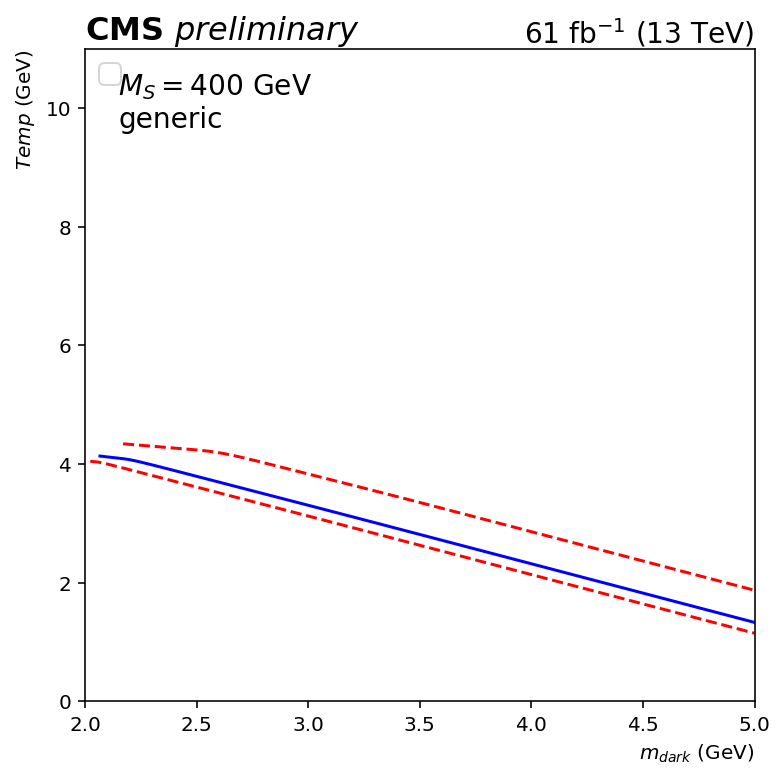

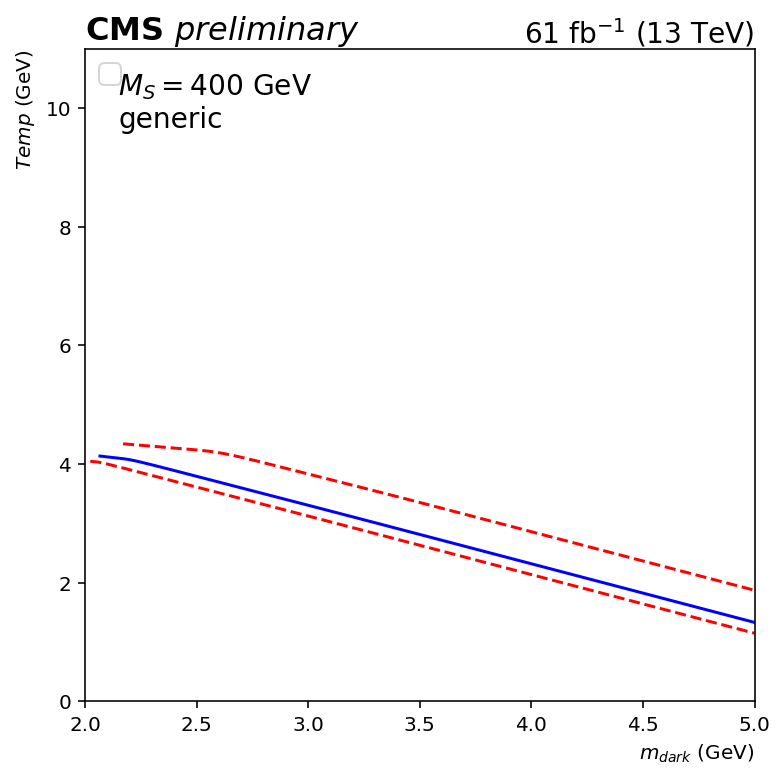

In [80]:
gr_limit = interpolate2DLimit(draw_mass_points=False)
gr_limit = interpolate2DLimit(draw_mass_points=False, preliminary=True)